This notebook demonstrates how to interpret the effects of categorical and numeric variables in a LightGBM model.

**Model Features:**
- **Categorical (3):** sector, size, industry
- **Numeric (10):** momentum, lagged_return, marketcap, pb, asset_growth, roe, gp_to_assets, grossmargin, assetturnover, leverage

### What is SHAP?

**SHAP (SHapley Additive exPlanations)** is a method for explaining individual predictions of machine learning models. It is based on Shapley values from cooperative game theory.

#### How SHAP Values are Computed

The SHAP value measures the contribution of each feature to a prediction by considering all possible combinations of features.

**The Formula:**

For each feature j, the SHAP value φⱼ is computed as a weighted average of the marginal contribution of that feature across all possible coalitions (subsets) of other features.

**Intuition:**
- Consider all possible ways to add features one-by-one to make a prediction
- For each way, measure how much the prediction changes when feature j is added
- Take a weighted average of these changes across all orderings
- The weights ensure each ordering is equally likely

**For tree-based models** (like LightGBM), SHAP uses an efficient algorithm:
1. Trace each prediction through the tree structure
2. Allocate credit to features at each split based on the change in prediction
3. Weight contributions by the proportion of training data following each path

#### Key Properties

**SHAP values satisfy four important properties:**

1. **Efficiency (Local Accuracy):** Sum of all SHAP values = Prediction - Average Prediction

2. **Symmetry:** If two features contribute equally, they get equal SHAP values

3. **Dummy:** A feature that does not affect the prediction gets SHAP value of zero

4. **Additivity:** For ensemble models, SHAP values add up correctly across individual components

#### Interpreting SHAP Values

- **Positive SHAP value:** The feature pushes the prediction higher than the base value
- **Negative SHAP value:** The feature pushes the prediction lower than the base value  
- **Magnitude:** Larger |SHAP value| means greater impact on the prediction
- **Base value:** The average prediction across all training data

**Example:** If base value = 0.50 and a feature has SHAP value = +0.10, that feature increases the prediction by 0.10, contributing to a final prediction closer to 0.60.

In [43]:
# Suppress joblib CPU detection warning on Windows
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Install and import required packages
# !pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 11

### 1. Load Model and Data

In [44]:
# Load the trained model
model_data = joblib.load('lightGBM.pkl')
model = model_data['model']
feature_cols = model_data['feature_cols']
categorical_features = model_data['categorical_features']
numeric_features = model_data['numeric_features']

print(f"Model: {type(model).__name__}")
print(f"Features: {len(feature_cols)} total")
print(f"  Categorical: {categorical_features}")
print(f"  Numeric: {len(numeric_features)} features")

Model: LGBMRegressor
Features: 13 total
  Categorical: ['sector', 'size', 'industry']
  Numeric: 10 features


In [45]:
# Load current data
df = pd.read_excel('currentdata.xlsx')

# Convert categorical variables to category dtype (as done in training)
for col in categorical_features:
    df[col] = df[col].astype('category')

# Make predictions
X = df[feature_cols]
df['predicted_return'] = model.predict(X)

print(f"Data shape: {df.shape}")
print(f"Month: {df['month'].iloc[0]}")
print(f"Prediction range: [{df['predicted_return'].min():.4f}, {df['predicted_return'].max():.4f}]")

Data shape: (2910, 16)
Month: 2025-10
Prediction range: [0.1850, 0.6084]


### 2. Interpreting Categorical Variables

Let's examine how predictions vary by categorical features (sector and size).

In [46]:
# Analyze predictions by sector
sector_stats = df.groupby('sector')['predicted_return'].agg(['mean', 'count']).sort_values('mean', ascending=False)
sector_stats.columns = ['Mean Prediction', 'Count']

print("MEAN PREDICTED RETURN BY SECTOR")
print("="*60)
print(sector_stats)
print(f"\nOverall mean: {df['predicted_return'].mean():.4f}")

MEAN PREDICTED RETURN BY SECTOR
                        Mean Prediction  Count
sector                                        
Financial Services             0.531602    559
Utilities                      0.520560     70
Real Estate                    0.510357    201
Consumer Defensive             0.507105    121
Industrials                    0.505222    398
Basic Materials                0.503775    145
Technology                     0.503502    420
Consumer Cyclical              0.500796    318
Energy                         0.494490    128
Communication Services         0.487848    100
Healthcare                     0.480336    450

Overall mean: 0.5054


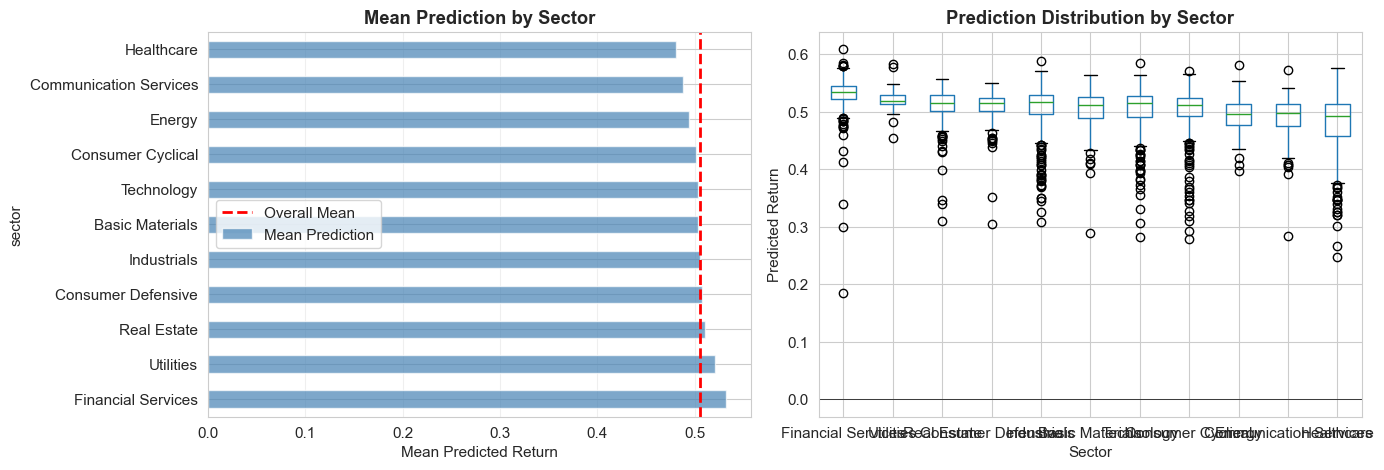

In [47]:
# Visualize sector effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean predictions by sector
ax = axes[0]
sector_stats["Mean Prediction"].plot(kind="barh", ax=ax, color="steelblue", alpha=0.7)
ax.axvline(x=df["predicted_return"].mean(), color="red", linestyle="--", 
           linewidth=2, label="Overall Mean")
ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Mean Predicted Return")
ax.set_title("Mean Prediction by Sector", fontweight="bold")
ax.legend()
ax.grid(axis="x", alpha=0.3)

# Distribution by sector
ax = axes[1]
sector_order = sector_stats.index.tolist()
df_plot = df[df["sector"].isin(sector_order)].copy()
df_plot["sector"] = pd.Categorical(df_plot["sector"], categories=sector_order, ordered=True)
df_plot.boxplot(column="predicted_return", by="sector", ax=ax)
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Sector")
ax.set_ylabel("Predicted Return")
ax.set_title("Prediction Distribution by Sector", fontweight="bold")
plt.suptitle("")  # Remove default title

plt.tight_layout()
plt.show()

In [48]:
# Analyze predictions by size
size_order = ["Mega-Cap", "Large-Cap", "Mid-Cap", "Small-Cap", "Micro-Cap", "Nano-Cap"]
size_stats = df.groupby("size")["predicted_return"].agg(["mean", "count"])
size_stats.columns = ["Mean Prediction", "Count"]

# Reorder if size categories exist in data
existing_sizes = [s for s in size_order if s in size_stats.index]
if existing_sizes:
    size_stats = size_stats.loc[existing_sizes]

print("MEAN PREDICTED RETURN BY SIZE")
print("="*60)
print(size_stats)
print(f"Overall mean: {df['predicted_return'].mean():.4f}")

MEAN PREDICTED RETURN BY SIZE
           Mean Prediction  Count
size                             
Mega-Cap          0.529856     64
Large-Cap         0.521890    831
Mid-Cap           0.512599   1051
Small-Cap         0.493510    806
Micro-Cap         0.432348    133
Nano-Cap          0.360503     25
Overall mean: 0.5054


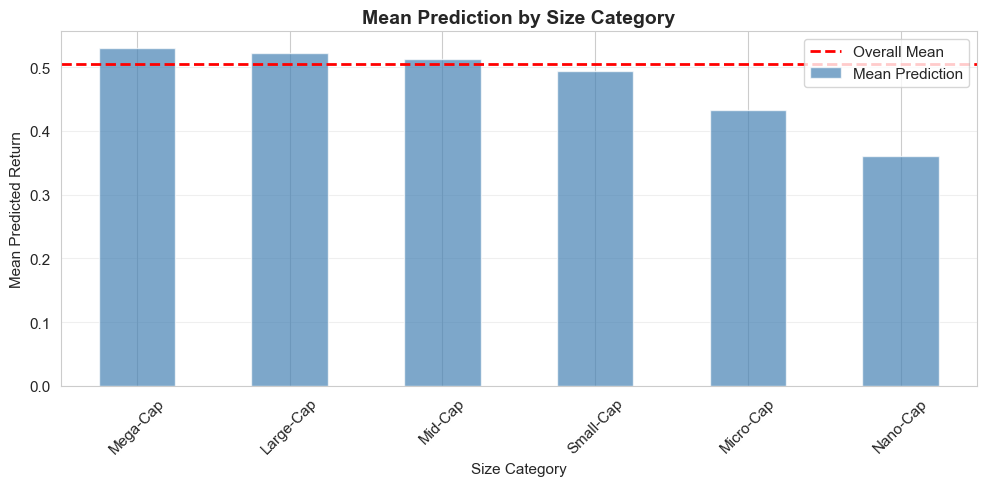

In [49]:
# Visualize size effects
if len(size_stats) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    size_stats["Mean Prediction"].plot(kind="bar", ax=ax, color="steelblue", alpha=0.7)
    ax.axhline(y=df["predicted_return"].mean(), color="red", linestyle="--", 
               linewidth=2, label="Overall Mean")
    ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax.set_ylabel("Mean Predicted Return")
    ax.set_xlabel("Size Category")
    ax.set_title("Mean Prediction by Size Category", fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No size data available to plot")

### 3. Interpreting Numeric Variables with SHAP

SHAP values show how each feature contributes to pushing predictions higher or lower.

In [50]:
# Create SHAP explainer
# Use a sample of data for faster computation
sample_size = min(1000, len(df))
X_sample = X.sample(n=sample_size, random_state=42)

print(f"Creating SHAP explainer with {sample_size} samples...")
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_sample)
print("SHAP values computed!")

Creating SHAP explainer with 1000 samples...
SHAP values computed!


#### Global Feature Importance

This shows which features have the largest impact on predictions overall (across all stocks).

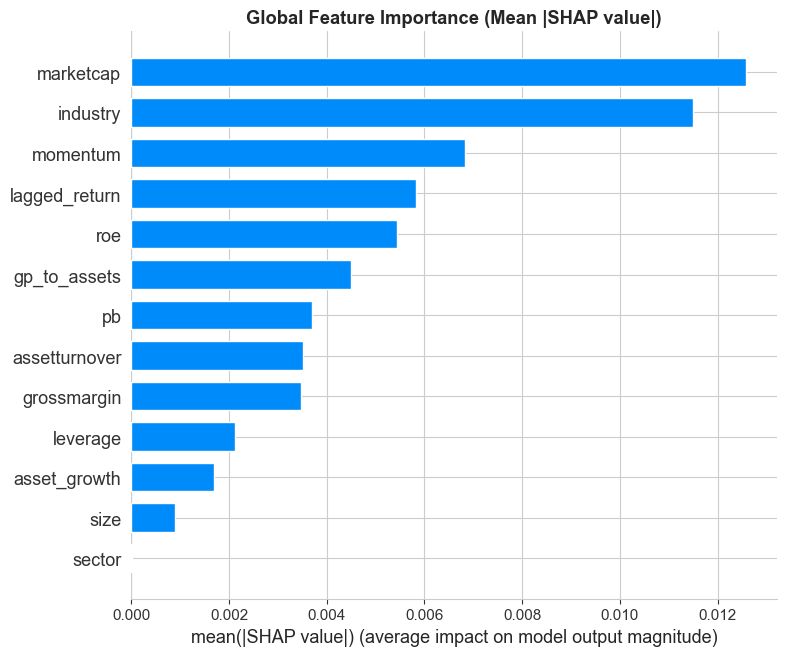

In [51]:
# Summary plot - shows feature importance and effect direction
plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=13, show=False)
plt.title('Global Feature Importance (Mean |SHAP value|)', fontweight='bold')
plt.tight_layout()
plt.show()

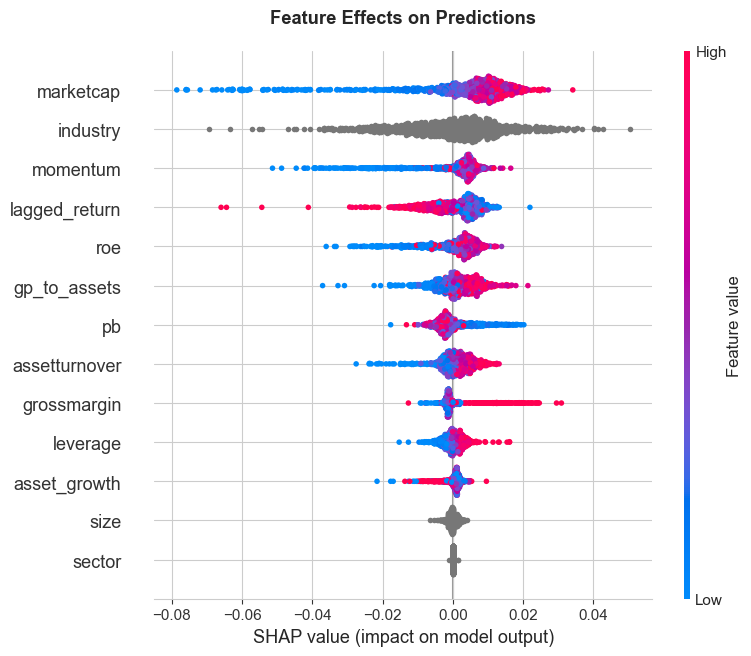

How to read this plot:
- Each dot is one stock
- Color shows feature value (red=high, blue=low)
- Position shows SHAP value (right=increases prediction, left=decreases)
- Example: High momentum (red) tends to increase predictions (positive SHAP)


In [53]:
# Detailed summary plot - shows feature values and their effects
plt.figure()
shap.summary_plot(shap_values, X_sample, max_display=13, show=False)
plt.title('Feature Effects on Predictions', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("How to read this plot:")
print("- Each dot is one stock")
print("- Color shows feature value (red=high, blue=low)")
print("- Position shows SHAP value (right=increases prediction, left=decreases)")
print("- Example: High momentum (red) tends to increase predictions (positive SHAP)")

#### Local Explanation: Single Stock Example

Let's examine one specific prediction in detail to see which features pushed it higher or lower.

In [54]:
# Pick an interesting example - highest predicted stock
idx = df['predicted_return'].idxmax()
stock_data = df.loc[idx]

print("EXAMPLE STOCK PREDICTION")
print("="*60)
print(f"Ticker: {stock_data['ticker']}")
print(f"Predicted Return: {stock_data['predicted_return']:.4f}")
print(f"Sector: {stock_data['sector']}")
print(f"Size: {stock_data['size']}")
print(f"Industry: {stock_data['industry']}")
print("\nTop numeric features:")
for feat in numeric_features[:5]:
    print(f"  {feat}: {stock_data[feat]:.4f}")

EXAMPLE STOCK PREDICTION
Ticker: PRAA
Predicted Return: 0.6084
Sector: Financial Services
Size: Small-Cap
Industry: Credit Services

Top numeric features:
  momentum: 0.1608
  lagged_return: 0.1117
  marketcap: 0.2625
  pb: 0.0801
  asset_growth: 0.6988


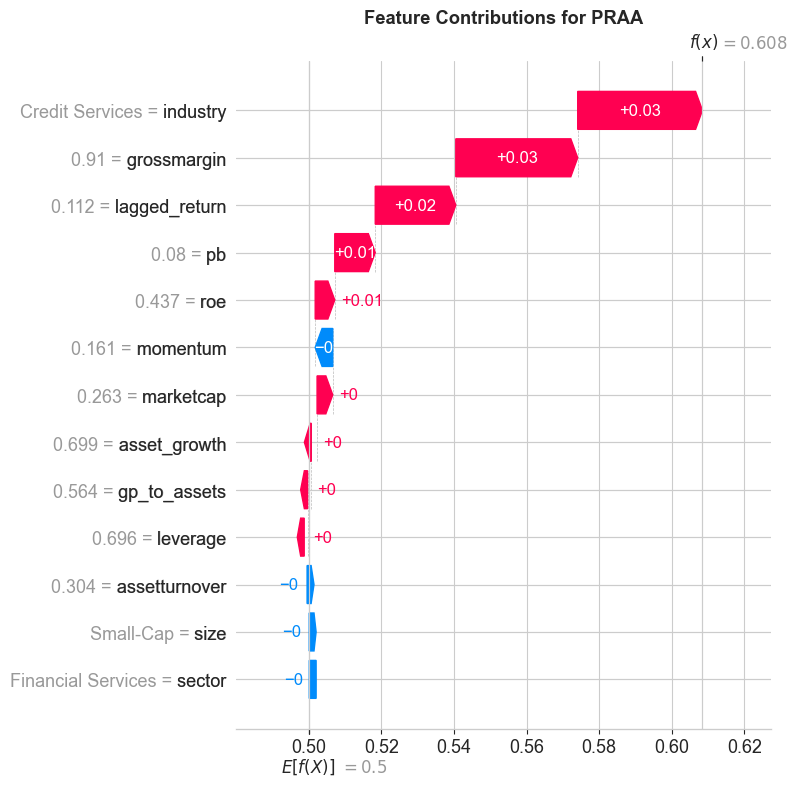


How to read this plot:
- E[f(X)] = base value (average prediction across all stocks)
- Each bar shows a feature's contribution (positive = push higher, negative = push lower)
- f(x) = final prediction after all features are considered
- The prediction is: base value + sum of all feature contributions


In [58]:
# Get SHAP values for this specific stock
stock_X = X.loc[idx:idx]
stock_shap = explainer(stock_X)

# Waterfall plot - shows how each feature contributes to this prediction
plt.figure()
shap.plots.waterfall(stock_shap[0], max_display=13, show=False)
plt.title(f'Feature Contributions for {stock_data["ticker"]}', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHow to read this plot:")
print("- E[f(X)] = base value (average prediction across all stocks)")
print("- Each bar shows a feature's contribution (positive = push higher, negative = push lower)")
print("- f(x) = final prediction after all features are considered")
print("- The prediction is: base value + sum of all feature contributions")

#### Dependence Plots: Feature Effects

These plots show how a feature's value affects its contribution to predictions.

<Figure size 640x480 with 0 Axes>

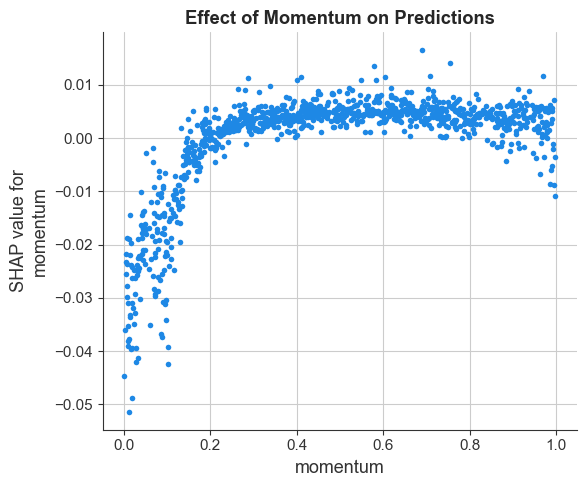


Interpretation:
- X-axis: momentum feature value (ranked)
- Y-axis: SHAP value (impact on prediction)
- Shows relationship between momentum and its effect on predicted returns


In [59]:
# Dependence plot for momentum
plt.figure()
shap.dependence_plot('momentum', shap_values.values, X_sample, interaction_index=None, show=False)
plt.title('Effect of Momentum on Predictions', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- X-axis: momentum feature value (ranked)")
print("- Y-axis: SHAP value (impact on prediction)")
print("- Shows relationship between momentum and its effect on predicted returns")

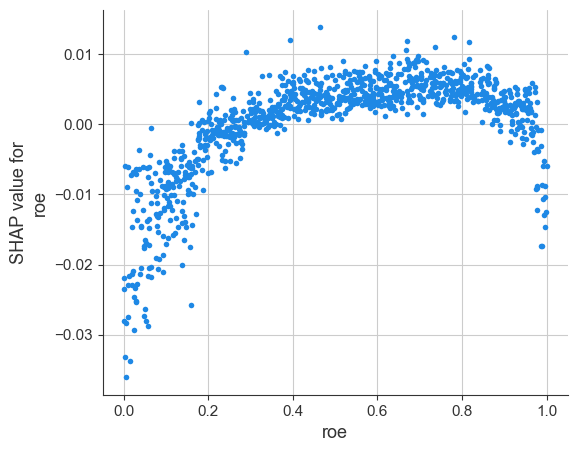

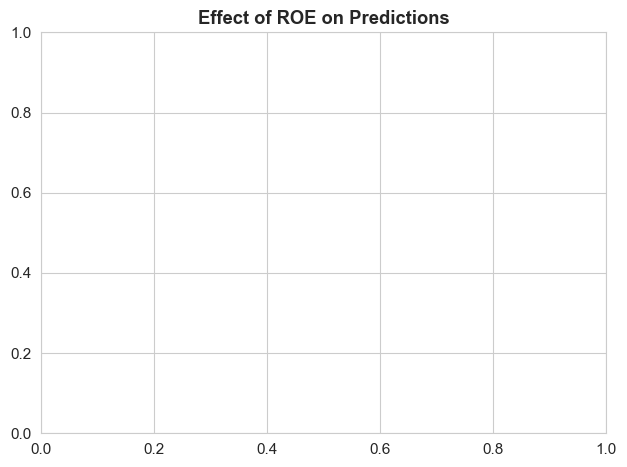

In [57]:
# Dependence plot for another key feature
shap.dependence_plot('roe', shap_values.values, X_sample, interaction_index=None)
plt.title('Effect of ROE on Predictions', fontweight='bold')
plt.tight_layout()
plt.show()

### Summary

**Categorical Variables:**
- We can interpret their effects by comparing mean predictions across categories
- Example: Different sectors and size categories show different expected returns

**Numeric Variables:**
- SHAP values quantify each feature's contribution to individual predictions
- Global importance shows which features matter most overall
- Local explanations (waterfall plots) show why a specific prediction was made
- Dependence plots reveal how feature values relate to their effects

**Key Insight:**
Both categorical and numeric features influence predictions, but we interpret them differently:
- Categorical: Compare group means and distributions
- Numeric: Use SHAP to quantify marginal contributions